In [1]:
import torch 
import torchvision
import torch.nn as nn
import torch.nn.functional as functional
import numpy as np
import matplotlib.pyplot as plt
import random

# Lets create labels for our dataset

In [2]:
classes = ['frame_num', 'action', 'team_controlling_ball', 'ball_x', 'ball_y', 'num_players_team1', 'num_players_team2', 'scene', 'no_team1_players']

for i in range(11):
    classes.append('team1_player' + str(i) + 'x')
    classes.append('team1_player' + str(i) + 'y')

classes.append('no_team1_players')

for i in range(11):
    classes.append('team2_player' + str(i) + 'x')
    classes.append('team2_player' + str(i) + 'y')
    
class_by_name = {} 
for i, item in enumerate(classes):
    class_by_name[item] = i

### Now we can printout an example row in our dataset

In [3]:
for i, value in enumerate(np.load("data.npy")[0]):
    print(f"idx {i}\t name: {classes[i]}\t\t\tvalue: {value}")

idx 0	 name: frame_num			value: 8707.0
idx 1	 name: action			value: 19
idx 2	 name: team_controlling_ball			value: 2.0
idx 3	 name: ball_x			value: 0.4796875
idx 4	 name: ball_y			value: 0.5388888888888889
idx 5	 name: num_players_team1			value: 6.0
idx 6	 name: num_players_team2			value: 11.0
idx 7	 name: scene			value: Midfield
idx 8	 name: no_team1_players			value: 6.0
idx 9	 name: team1_player0x			value: 0.809375
idx 10	 name: team1_player0y			value: 0.3763888888888889
idx 11	 name: team1_player1x			value: 0.96875
idx 12	 name: team1_player1y			value: 0.6041666666666666
idx 13	 name: team1_player2x			value: 0.4640625
idx 14	 name: team1_player2y			value: 0.40694444444444444
idx 15	 name: team1_player3x			value: 0.78828125
idx 16	 name: team1_player3y			value: 0.45416666666666666
idx 17	 name: team1_player4x			value: 0.4390625
idx 18	 name: team1_player4y			value: 0.44166666666666665
idx 19	 name: team1_player5x			value: 0.71171875
idx 20	 name: team1_player5y			value: 0.49027777777

# Creating custom dataloader with support for
- changing the input file
- changin the output folder
- shuffle of the data on/off


In [4]:
import os
from torch.utils.data import Dataset

class FootballData(Dataset):

    def idx_to_name(self, idx):
        return f"{self.out_path}/record{idx}.npy"
    
    def __init__(self, path, out_path='./barca_dataset', shuffle=False):
        self.out_path = out_path
        self.shuffle = shuffle
        raw_data = np.load(path)
        self.size = len(raw_data) - 1
        if not os.path.isdir(self.out_path):
            os.mkdir(self.out_path)
        for i, record in enumerate(raw_data):
            name = self.idx_to_name(i)
            if not os.path.isfile(name):
                np.save(name, record)

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        if self.shuffle:
            idx = random.randint(0, self.size)
        data = np.load(self.idx_to_name(idx))
        inputs = torch.tensor([[[float(data[3]),float(data[4])]]], dtype=torch.float)
    
        label = torch.tensor([int(data[1])])
        return inputs.float(), label

In [5]:
data_loader = FootballData("./data.npy", out_path="data_unloaded")

# Creating our CNN

We will take the position of the ball as an input and the action will be our label

In [6]:
class ActionClssifier(nn.Module):
    def __init__(self):
      super(ActionClssifier, self).__init__()
      self.stack = nn.Sequential(
        nn.Conv1d(1,1,1),
        nn.ReLU(),
        nn.MaxPool1d(1),
        nn.ReLU(),
        nn.Linear(2,30,bias=False),
        nn.ReLU(),
        nn.Linear(30,30,bias=False),
        nn.Softmax(dim=1),
        nn.Linear(30, 41),
      )
    def forward(self,x):
      return self.stack(x)

model = ActionClssifier()

# Creating cutsom training function

In [7]:
def train_loop(model, dataloader, loss_fn, optimizer, untill=50_000, log_freq=2000):
  loss_data = []
  running_loss = 0
  for batch, data in enumerate(dataloader,0):
    # inputs, label = data[0].to(device), data[1].to(device)
    inputs, label = data
    optimizer.zero_grad()
    prediction = model(inputs)
    loss = loss_fn(prediction.view(1, 41), label).float()
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
    if batch % log_freq == log_freq-1:
        temp_loss = running_loss/(log_freq)
        print(f"Loss: {temp_loss:.4f},\t{100 * batch/len(dataloader):.0f}% of data complete")
        loss_data.append(temp_loss)
        running_loss = 0
    if batch == untill:
       return loss_data

### Now we can train our network

Unfortunetly despite many attempts i was not able to train the network to any accebtable results 😥 

In [8]:
learning_rate = 0.001
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

data = []
data += train_loop(model=model,
           dataloader=data_loader,
           loss_fn=loss_fn,
           optimizer=optimizer)

data += train_loop(model=model,
           dataloader=data_loader,
           loss_fn=loss_fn,
           optimizer=optimizer)

Loss: 1.9267,	4% of data complete
Loss: 2.2346,	8% of data complete
Loss: 2.0747,	12% of data complete
Loss: 2.3912,	16% of data complete
Loss: 1.7464,	20% of data complete
Loss: 1.7431,	23% of data complete
Loss: 2.1982,	27% of data complete
Loss: 2.1572,	31% of data complete
Loss: 1.9117,	35% of data complete
Loss: 1.9492,	39% of data complete
Loss: 2.3997,	43% of data complete
Loss: 1.5183,	47% of data complete
Loss: 1.8273,	51% of data complete
Loss: 1.6497,	55% of data complete
Loss: 1.5280,	59% of data complete
Loss: 1.6779,	63% of data complete
Loss: 1.9050,	66% of data complete
Loss: 2.2163,	70% of data complete
Loss: 2.1945,	74% of data complete
Loss: 2.0340,	78% of data complete
Loss: 1.9870,	82% of data complete
Loss: 1.7505,	86% of data complete
Loss: 1.9529,	90% of data complete
Loss: 1.8110,	94% of data complete
Loss: 2.4043,	98% of data complete
Loss: 1.8935,	4% of data complete
Loss: 2.2261,	8% of data complete
Loss: 2.0696,	12% of data complete
Loss: 2.3886,	16% of dat

### Lets plot the results

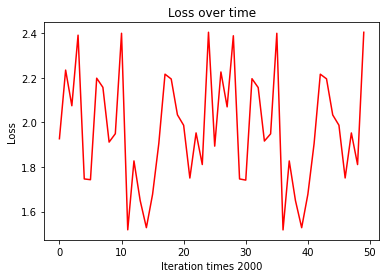

In [9]:
plt.yscale('linear')
plt.title("Loss over time")
plt.xlabel("Iteration times 2000")
plt.ylabel("Loss")
plt.plot(data, color="r")
plt.show()

### And check the accuracy...

In [10]:
acc = 0
for batch, data in enumerate(data_loader):
    inputs, label = data
    prediction = model(inputs)
    prediction = prediction.detach().numpy()
    
    if np.argmax(prediction) == label.item():
        acc +=1

    if batch == len(data_loader)-1:
        break
        
import statistics
print(f"Performance {acc/(len(data_loader)-1)}")

Performance 0.07671704236641967
